# Optimization using scipy

In [1]:
from scipy.optimize import rosen, differential_evolution
from scipy.integrate import simps
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as polynomial
from scipy.interpolate import UnivariateSpline
import h5py
import damask
import os
import re
import matplotlib.pyplot as plt
import subprocess
import shlex
from shutil import copy
%matplotlib inline

In [2]:
bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]
#         B, D_a, Q_cl, omega, Q_s, i_sl, rho

In [6]:
result = differential_evolution(rosen, bounds)

In [7]:
expt_folder = '/nethome/v.shah/Validation_Kees/Ni_30Fe/sample_files/'

## Find the range limits for the parameters

In [2]:
from damask import ConfigMaterial as cm

In [3]:
mat = cm.load('/nethome/v.shah/Validation_Kees/Steels/sample_files/material.yaml')

In [4]:
mat['phase']['Austenite']['mechanics']['plasticity']

{'B': [0.01],
 'D': 2e-05,
 'D_0': 4e-05,
 'D_a': 6.0,
 'Gamma_sf_0K': -0.0396,
 'dGamma_sf_dT': 0.0002,
 'N_sl': [12],
 'N_tr': [0],
 'N_tw': [0],
 'Q_cl': 4e-19,
 'omega': 1100.0,
 'Q_s': [3e-19],
 'b_sl': [2.56e-10],
 'f_at': 1.0,
 'h_sl_sl': [0.122, 0.122, 0.625, 0.07, 0.137, 0.122],
 'i_sl': [18.0],
 'output': ['rho_mob', 'rho_dip'],
 'p_sl': [0.32],
 'q_sl': [1.46],
 'rho_dip_0': [100000000000.0],
 'rho_mob_0': [100000000000.0],
 'tau_0': ['1.5e8'],
 'type': 'dislotwin',
 'v_0': ['1.0e5'],
 'v_sb': 0.0}

In [6]:
parameters_range = {
    #'B': [1e-03,0.1],
    #'D_a': [1.0,8.0],
    #'Q_cl': [3e-19,5E-19],
    #'omega': [800.0,1200.0]
    #'Q_s': [3e-19,5E-19],
    #'i_sl': [10.0,20.0],
    #'rho_dip_0': [1E9,5E9],
    #'tau_0': [1E7,3E8],
    #'v_0': [1E1,1E5],
    'p_sl': [0.16,0.64],
}

simulation_p_sl_0.16


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-7-d69bb8c4bb87>:41: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_p_sl_0.64


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-7-d69bb8c4bb87>:41: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


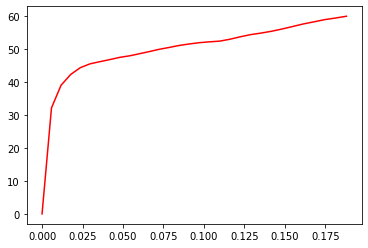

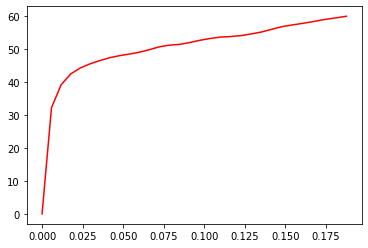

In [7]:
for i in parameters_range.keys():
    for r in parameters_range[i]:
        sim_path = f'simulation_{i}_{r}'
        print(sim_path)
        try:
            os.mkdir(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/')
        except:                           #sometimes code wants to rerun same optimizations...
            os.chdir(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/')
            
        copy('/nethome/v.shah/Validation_Kees/Steels/sample_files/material.yaml',\
             f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/material.yaml')
        copy('/nethome/v.shah/Validation_Kees/Steels/sample_files/3D_random.vtr',\
             f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/3D_random.vtr')
        copy('/nethome/v.shah/Validation_Kees/Steels/sample_files/tensionX.yaml',\
             f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/tensionX.yaml')
    
        os.chdir(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/')
        from damask import ConfigMaterial as cm
        mat = cm.load('material.yaml')
        if i != 'rho_dip_0':
            mat['phase']['Austenite']['mechanics']['plasticity'][i] = [float(r)]
        else:
            mat['phase']['Austenite']['mechanics']['plasticity']['rho_dip_0'] = [float(r)]
            mat['phase']['Austenite']['mechanics']['plasticity']['rho_mob_0'] = [float(r)]
        mat.save('material.yaml')
        
        cmd = 'DAMASK_grid -l tensionX.yaml -g 3D_random.vtr'
        p = subprocess.Popen(cmd,shell=True)
        while p.poll() == None:
          p.poll()
    
        d = damask.Result('3D_random_tensionX.hdf5')
        d.add_stress_Cauchy()
        d.add_strain()
        d.add_equivalent_Mises('sigma')
        d.add_equivalent_Mises('epsilon_V^0.0(F)')
        
        stress_list = []
        strain_list = []
    
        hdf = h5py.File(d.fname)
        for count,inc in enumerate(d.get_dataset_location('sigma_vM')):
            stress_list.append(np.average(hdf[inc]))
            strain_path = inc.split('sigma_vM')[0] + 'epsilon_V^0.0(F)_vM'
            strain_list.append(np.average(hdf[strain_path]))
        
        stress_array = np.array(stress_list).reshape((len(stress_list),1))/1E6
        strain_array = np.array(strain_list).reshape((len(strain_list),1))
        
        # plotting stress strain curve
        fig = plt.figure()
        plt.plot(strain_array,stress_array,color='red')
        fig.savefig(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/stress_strain.png')

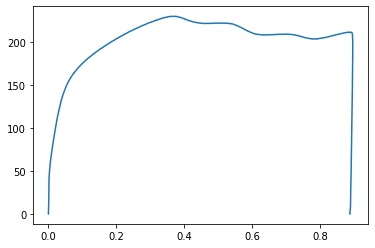

In [11]:
plt.plot(df['True Strain'],df['True Stress'])

In [12]:
df = df.loc[df['True Strain']< 0.2]

In [12]:
df

,Unnamed: 0,Time (s),Temperature (°C),Change in Length (µm),Force (N),Change in length (µm),Abs. Change in length (µm),Eng. Strain,Eng. Stress (MPa),Length (µm),True Strain,True Stress
0,4,0.000958,999.203430,80.129005,10.600432,0.000000,0.000000,0.000000,0.539876,10.000000,0.000000,0.539876
1,5,0.001274,999.178467,79.966232,10.680738,-0.162773,0.162773,-0.000016,0.543966,9.999837,0.000016,0.543957
2,6,0.001600,999.369263,80.590210,12.420709,0.461205,-0.461205,0.000046,0.632581,10.000461,-0.000046,0.632611
3,7,0.001916,999.375610,80.548386,12.376094,0.419380,-0.419380,0.000042,0.630309,10.000419,-0.000042,0.630336
4,8,0.002231,999.448853,81.161438,13.069108,1.032433,-1.032433,0.000103,0.665604,10.001032,-0.000103,0.665673
...,...,...,...,...,...,...,...,...,...,...,...,...
836,840,0.268311,1003.176636,-1719.803467,4865.898926,-1799.932472,1799.932472,-0.179993,247.818197,8.200068,0.198443,203.212595
837,841,0.268641,1003.176209,-1722.466064,4869.412598,-1802.595070,1802.595070,-0.180260,247.997147,8.197405,0.198767,203.293304
838,842,0.268957,1003.227600,-1724.882080,4873.200684,-1805.011086,1805.011086,-0.180501,248.190073,8.194989,0.199062,203.391490
839,843,0.269277,1003.261841,-1727.408325,4876.448730,-1807.537331,1807.537331,-0.180754,248.355494,8.192463,0.199371,203.464312


In [50]:
c1 = polynomial.polyfit(df['True Strain'],df['True Stress'],deg=17)

In [51]:
fit = polynomial.polyval(df['True Strain'], c1)

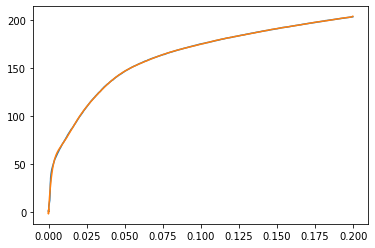

In [52]:
plt.plot(df['True Strain'],df['True Stress'])
plt.plot(df['True Strain'],fit)

In [13]:
area = simps(df['True Strain'],df['True Stress'])

In [14]:
area

8.31249780923785

In [2]:
def opt_DAMASK(x):
    #B = x[0]
    #D_a = x[0]
    Q_cl = x[0]
    omega = x[1]
    #Q_s = x[0]
    i_sl = x[2]
    #p_sl = x[1]
    #q_sl = x[2]
    #rho = x[3]
    #tau_0  = x[4]
    #v_0  = x[5]
    
    #sim_path = f'simulation_{B:.2e}_{D_a:.2e}_{Q_cl:.2e}_{omega:.2e}_{Q_s:.2e}_{i_sl:.2e}_{rho:.2e}'
    sim_path = f'simulation_{Q_cl:.2e}_{omega:.2e}_{i_sl:.2e}'
    print(sim_path)
    try:
        os.mkdir(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/')
    except:                           #sometimes code wants to rerun same optimizations...
        os.chdir(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/')
    copy('/nethome/v.shah/Validation_Kees/Steels/sample_files/material.yaml',f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/material.yaml')
    copy('/nethome/v.shah/Validation_Kees/Steels/sample_files/3D_random.vtr',f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/3D_random.vtr')
    copy('/nethome/v.shah/Validation_Kees/Steels/sample_files/tensionX.yaml',f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/tensionX.yaml')
    
    os.chdir(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}/')
    from damask import ConfigMaterial as cm
    mat = cm.load('material.yaml')
    #mat['phase']['Austenite']['mechanics']['plasticity']['B'] = [float(B)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['D_a'] = float(D_a)
    mat['phase']['Austenite']['mechanics']['plasticity']['Q_cl'] = float(Q_cl)
    mat['phase']['Austenite']['mechanics']['plasticity']['omega'] = float(omega)
    #mat['phase']['Austenite']['mechanics']['plasticity']['Q_s'] = [float(Q_s)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['i_sl'] = [float(i_sl)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['i_sl'] = [float(i_sl)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['p_sl'] = [float(p_sl)]
    mat['phase']['Austenite']['mechanics']['plasticity']['i_sl'] = [float(i_sl)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['tau_0'] = [float(tau_0)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['rho_dip_0'] = [float(rho)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['rho_mob_0'] = [float(rho)]
    #mat['phase']['Austenite']['mechanics']['plasticity']['v_0'] = [float(v_0)]
    mat.save('material.yaml')
    
    cmd = 'DAMASK_grid -l tensionX.yaml -g 3D_random.vtr'
    p = subprocess.Popen(cmd,shell=True)
    while p.poll() == None:
      p.poll()
    
    d = damask.Result('3D_random_tensionX.hdf5')
    d.add_stress_Cauchy()
    d.add_strain()
    d.add_equivalent_Mises('sigma')
    d.add_equivalent_Mises('epsilon_V^0.0(F)')
    
    stress_list = []
    strain_list = []
    
    hdf = h5py.File(d.fname)
    for count,inc in enumerate(d.get_dataset_location('sigma_vM')):
        stress_list.append(np.average(hdf[inc]))
        strain_path = inc.split('sigma_vM')[0] + 'epsilon_V^0.0(F)_vM'
        strain_list.append(np.average(hdf[strain_path]))
        
    stress_array = np.array(stress_list).reshape((len(stress_list),1))/1E6
    strain_array = np.array(strain_list).reshape((len(strain_list),1))
    
    # fit polynomials and then use least squares
    df_sim = pd.DataFrame({'True Strain': strain_list,'True Stress':stress_list})
    df_sim = df_sim.loc[df_sim['True Strain']< 0.15]
    f = UnivariateSpline(df_sim['True Strain'],df_sim['True Stress'],k=3,s=None)
    xnew1 = np.array([0.05,0.1,0.15])
    ynew1 = f(xnew1)
    
#     df = pd.read_excel('/nethome/v.shah/Validation_Kees/Ni_30Fe/sample_files/01_FullStressStrain_Ni30Fe_1000C-1s-1.xlsx',header=4,usecols='A:L',engine='openpyxl')
    df = pd.read_csv('/nethome/v.shah/Validation_Kees/Steels/tmp/10779R1-376_DP6_A-1200_1.asc',\
                     header=2,sep='\\s+',names=['True Strain','True Stress','Time'],encoding= 'unicode_escape')
    df = df.loc[df['True Strain']< 0.6]
    c = polynomial.polyfit(df['True Strain'],df['True Stress'],9)
    #xnew = np.linspace(0.02,0.15,20)
    xnew = np.array([0.05,0.1,0.15])
    ynew = polynomial.polyval(xnew,c)
    
    # plotting stress strain curve
    fig = plt.figure()
    plt.plot(strain_array,stress_array,color='red')
    plt.plot(df['True Strain'],df['True Stress'],color='black')
    plt.plot(xnew,ynew,marker='+')
    plt.plot(xnew1,ynew1/1E6,marker='o')
    fig.savefig(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/{sim_path}.png')
    
    area_res = np.sum(np.abs(ynew*1E6 - ynew1))
    with open(f'/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/residual.txt','a') as f:
        #f.write(f'\n {area_res} \n B={B:.2e}|D_a={D_a:.2e}|Q_cl={Q_cl:.2e}|omega={omega:.2e}|Q_s={Q_s:.2e}|i_sl={i_sl:.2e}|rho={rho:.2e}\n')
        f.write(f'{area_res:.2e} Q_cl: {Q_cl:.2e} omega: {omega:.2e} i_sl: {i_sl:.2e}\n')

    return area_res

In [4]:
bounds=[(2.95E-19,3.15E-19),(500.0,800.0),(16.0,20.0)]
# D_a, Q_cl, omega, i_sl
#bounds = [(3.75e-19,4.5e-19),(0.25,0.5),(1.20,1.7),(1E9,1E11),(0.1E8,10E8),(1.0E4,1.0E6)]
# Q_s,p_sl,q_sl,rho_mob_0,tau_0,v0

In [ ]:
res = differential_evolution(func=opt_DAMASK,bounds=bounds,seed=1,polish=False,atol=1E5,workers=1,disp=True,\
                             maxiter=10,popsize=15,updating='deferred')

simulation_2.96e-19_5.78e+02_1.75e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_3.05e-19_6.93e+02_1.90e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_3.05e-19_7.65e+02_1.99e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_3.14e-19_7.33e+02_2.00e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_3.11e-19_5.08e+02_1.67e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_2.97e-19_6.50e+02_1.88e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


simulation_2.98e-19_5.59e+02_1.69e+01


 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00
<ipython-input-2-81460a860a94>:57: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


In [5]:
res

     fun: 11563252.11348188
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 180
     nit: 3
 success: False
       x: array([4.02075876e-19, 1.11800810e+03, 2.00400854e+01])

In [2]:
df = pd.read_csv('/nethome/v.shah/Validation_Kees/Steels/tmp/10778R1-376_DP6_A-1200_0.1.asc',header=2,sep='\\s+',names=['True Strain','True Stress','Time'])

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb2 in position 4: invalid start byte

In [96]:
df_exp = pd.read_csv('/nethome/v.shah/Validation_Kees/Steels/tmp/10778R1-376_DP6_A-1200_0.1.asc',\
                 header=2,sep='\\s+',names=['True Strain','True Stress','Time'],encoding= 'unicode_escape')

In [9]:
os.chdir('/nethome/v.shah/Validation_Kees/Ni_30Fe/Optimization/simulation_6.69e+00_3.95e-19_2.03e+01')

In [10]:
d = damask.Result('3D_random_tensionX.hdf5')
stress_list = []
strain_list = []
hdf = h5py.File(d.fname)
for count,inc in enumerate(d.get_dataset_location('sigma_vM')):
    stress_list.append(np.average(hdf[inc]))
    strain_path = inc.split('sigma_vM')[0] + 'epsilon_V^0.0(F)_vM'
    strain_list.append(np.average(hdf[strain_path]))
        
stress_array = np.array(stress_list).reshape((len(stress_list),1))/1E6
strain_array = np.array(strain_list).reshape((len(strain_list),1))

<ipython-input-10-1f3efac48981>:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hdf = h5py.File(d.fname)


In [11]:
df = pd.DataFrame({'True Strain': strain_list,'True Stress':stress_list})

In [12]:
from scipy.interpolate import UnivariateSpline
f = UnivariateSpline(df['True Strain'],df['True Stress'],k=3,s=None)
xnew1 = np.linspace(0.02,0.1,20)
ynew1 = f(xnew1)

error: (m>k) failed for hidden m: fpcurf0:m=0

In [118]:
# df = df.loc[df['True Strain']< 0.15]
c1 = polynomial.polyfit(df['True Strain'],df['True Stress'],9)
xnew1 = np.linspace(0.02,0.1,20)
ynew1 = polynomial.polyval(xnew1,c1)

In [119]:
df1 = pd.read_csv('/nethome/v.shah/Validation_Kees/Steels/tmp/10780R1-376_DP6_A-1200_10.asc',\
                     header=2,sep='\\s+',names=['True Strain','True Stress','Time'],encoding= 'unicode_escape')
# df1 = df1.loc[df1['True Strain']< 0.15]
c = polynomial.polyfit(df1['True Strain'],df1['True Stress'],9)
xnew = np.linspace(0.02,0.15,20)
ynew = polynomial.polyval(xnew,c)

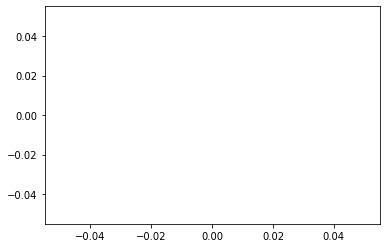

In [13]:
plt.plot(df['True Strain'],df['True Stress'])
# plt.plot(df1['True Strain'],df1['True Stress']*1E6)
# plt.plot(xnew,ynew*1E6,marker='+')
# plt.plot(xnew1,ynew1,marker='o')

In [24]:
c

array([-1.09998072e+00,  8.29555355e+02, -2.27757234e+04,  4.93278335e+05,
       -6.76107580e+06,  5.46440007e+07, -2.36422812e+08,  4.20245612e+08])

In [28]:
ynew

array([-1.09998072,  4.24767571,  7.89169769, 10.56480226, 12.68901223,
       14.48721557, 16.06565605, 17.47140372, 18.72885376, 19.85930218,
       20.88764699, 21.8402633 , 22.73810083, 23.58905257, 24.38364282,
       25.09808344, 25.70874653, 26.22210243, 26.72417121, 27.45353645])

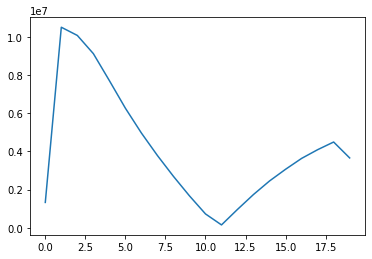

In [53]:
plt.plot(np.abs(ynew*1E6 - ynew1))

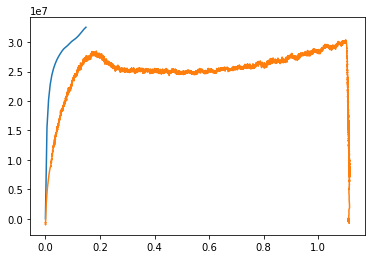

In [17]:
plt.plot(df['True Strain'],df['True Stress'])
plt.plot(df_exp['True Strain'],df_exp['True Stress']*1E6)

In [2]:
df = pd.read_csv('/nethome/v.shah/Validation_Kees/Steels/tmp/10780R1-376_DP6_A-1200_10.asc',\
                     header=2,sep='\\s+',names=['True Strain','True Stress','Time'],encoding= 'unicode_escape')

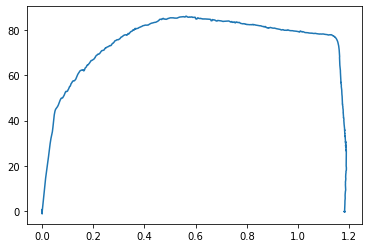

In [3]:
plt.plot(df['True Strain'],df['True Stress'])

In [12]:
fitting_results = np.loadtxt('/nethome/v.shah/Validation_Kees/Steels/Optimization_attempts/residual.txt',usecols=(0,2,4,6))

In [13]:
fitting_results = pd.DataFrame({'Residual': fitting_results[:,0],'Q_cl':fitting_results[:,1],'omega':fitting_results[:,2],\
                                'i_sl':fitting_results[:,3]})

In [14]:
fitting_results[0:50]

,Residual,Q_cl,omega,i_sl
0,9730000.0,3.050000e-19,578.0,18.8
1,12100000.0,3.130000e-19,693.0,22.5
2,15900000.0,3.130000e-19,765.0,24.8
3,14000000.0,3.190000e-19,733.0,25.0
4,19300000.0,3.170000e-19,508.0,16.8
5,14200000.0,3.060000e-19,650.0,22.1
6,8260000.0,3.070000e-19,559.0,17.2
7,14400000.0,3.140000e-19,620.0,23.7
8,17300000.0,3.080000e-19,586.0,15.2
9,16200000.0,3.070000e-19,673.0,23.6


In [61]:
plt.scatter(fitting_results['D_a'],fitting_results['Q_cl'],c=np.log(fitting_results['Residual']))
plt.xlabel('D_a')
plt.ylabel('Q_cl')
plt.colorbar()

KeyError: 'D_a'

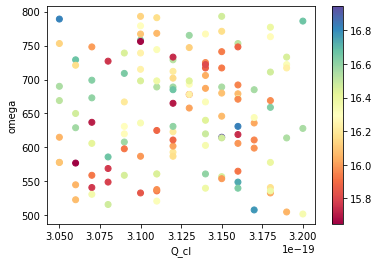

In [15]:
plt.scatter(fitting_results['Q_cl'],fitting_results['omega'],c=np.log(fitting_results['Residual']),cmap='Spectral')
plt.xlabel('Q_cl')
plt.ylabel('omega')
plt.colorbar()

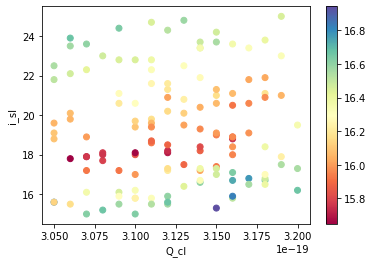

In [16]:
plt.scatter(fitting_results['Q_cl'],fitting_results['i_sl'],c=np.log(fitting_results['Residual']),cmap='Spectral')
plt.xlabel('Q_cl')
plt.ylabel('i_sl')
plt.colorbar()

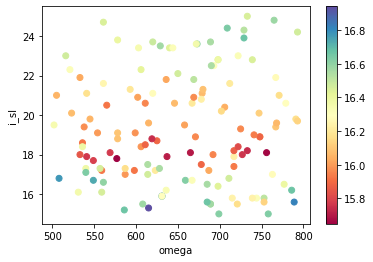

In [17]:
plt.scatter(fitting_results['omega'],fitting_results['i_sl'],c=np.log(fitting_results['Residual']),cmap='Spectral')
plt.xlabel('omega')
plt.ylabel('i_sl')
plt.colorbar()

In [14]:
f = h5py.File('3D_random_tensionX.hdf5','r')

In [16]:
f.keys()

<KeysViewHDF5 ['geometry', 'inc0', 'inc10', 'inc100', 'inc1000', 'inc110', 'inc1100', 'inc120', 'inc1200', 'inc130', 'inc1300', 'inc140', 'inc1400', 'inc150', 'inc1500', 'inc160', 'inc1600', 'inc170', 'inc1700', 'inc180', 'inc1800', 'inc190', 'inc1900', 'inc20', 'inc200', 'inc2000', 'inc210', 'inc2100', 'inc220', 'inc2200', 'inc230', 'inc2300', 'inc240', 'inc2400', 'inc250', 'inc2500', 'inc260', 'inc270', 'inc280', 'inc290', 'inc30', 'inc300', 'inc310', 'inc320', 'inc330', 'inc340', 'inc350', 'inc360', 'inc370', 'inc380', 'inc390', 'inc40', 'inc400', 'inc410', 'inc420', 'inc430', 'inc440', 'inc450', 'inc460', 'inc470', 'inc480', 'inc490', 'inc50', 'inc500', 'inc60', 'inc600', 'inc70', 'inc700', 'inc80', 'inc800', 'inc90', 'inc900', 'mapping']>

In [17]:
rho_dip = np.array(f['/inc2500/phase/Austenite/plastic/rho_dip'])
rho_mob = np.array(f['/inc2500/phase/Austenite/plastic/rho_mob'])

In [18]:
np.average(np.sum(np.concatenate((rho_dip,rho_mob),axis=1),axis=1))

215316847485095.7

In [19]:
rows,columns = np.where(rho_dip < 1E10)

In [20]:
rho_dip[rows]

array([[6.96612971e+10, 4.24813759e+10, 4.29371477e+10, ...,
        8.69969316e+10, 1.53187001e+13, 2.15921909e+13],
       [1.28253980e+10, 3.18485457e+10, 4.58376486e+10, ...,
        7.86649738e+10, 5.73335301e+13, 7.34912929e+13],
       [1.28253980e+10, 3.18485457e+10, 4.58376486e+10, ...,
        7.86649738e+10, 5.73335301e+13, 7.34912929e+13],
       ...,
       [4.74279499e+10, 4.90157480e+13, 2.56587917e+10, ...,
        1.06488217e+12, 2.07104756e+09, 2.74203874e+08],
       [4.74279499e+10, 4.90157480e+13, 2.56587917e+10, ...,
        1.06488217e+12, 2.07104756e+09, 2.74203874e+08],
       [4.74279499e+10, 4.90157480e+13, 2.56587917e+10, ...,
        1.06488217e+12, 2.07104756e+09, 2.74203874e+08]])

In [21]:
tot_dip = np.sum(rho_dip,axis=1)

In [24]:
np.where(tot_dip < 12*1E11)

(array([], dtype=int64),)

In [25]:
tot_density = np.sum(np.concatenate((rho_dip,rho_mob),axis=1),axis=1)

In [26]:
np.where(tot_density < 24*1E11)

(array([], dtype=int64),)

In [135]:
tot_dip[4]

77360932202.47174